In [2]:
# Import Python libraries (use Python >= v. 3.9.0)
#-------------------------------------------------

import networkx as nx
import osmnx as ox
import pandas as pd
import folium
import plotly
import plotly.graph_objects as go

from branca.element import Template, MacroElement

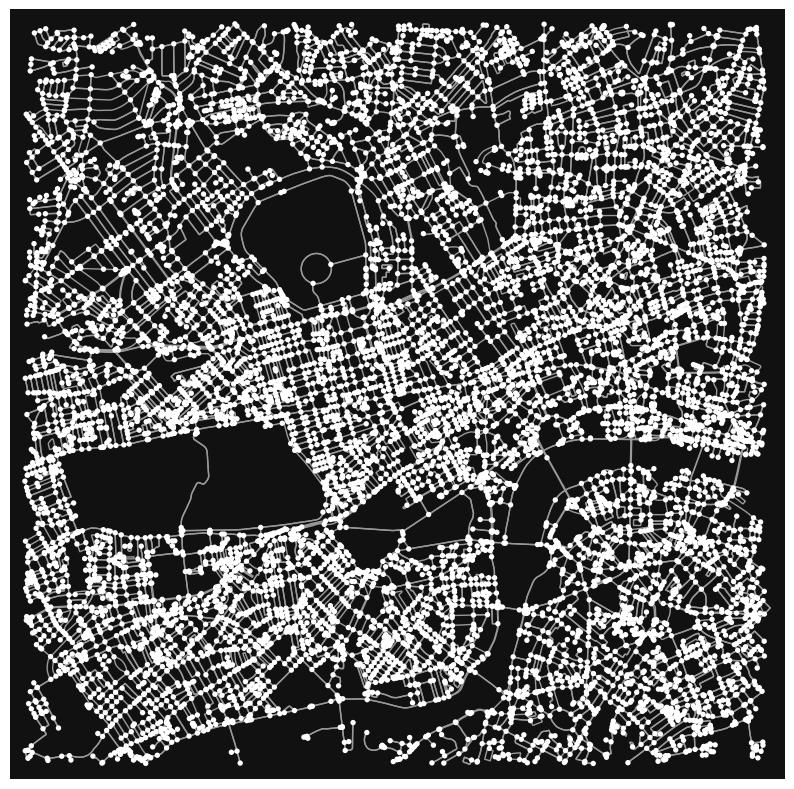

In [3]:

#Create a OSMnx driveable urban network graph 4000 meters from a point in Central London
#---------------------------------------------------------------------------------------

point = 51.515472, -0.141336 #-------------- Coordinates of the Oxford Circus Underground tubestop

G = ox.graph.graph_from_point(point, dist=4000, simplify=True,  network_type='drive')

# The following code can be run to decrease the time required to generate OSMnx network graphs.
# If a node cannot access at least 10% of other nodes it is removed from the network
#---------------------------------------------------------------------------------------

remove_list = []
num_nodes = len(G.nodes)
for node in G.nodes:  
     reach = len(nx.descendants(G, node))
     if reach < num_nodes / 10:
         remove_list.append(node)
for node in remove_list:
     G.remove_node(node)

#---------------------------------------------------------------------------------------
ox.plot_graph(G, figsize = (10,10));

In [4]:
# Add freeflow travel time as an edge attribute in in case speed data ime not available in Uber Movement dataset
#---------------------------------------------------------------------------------------

G = ox.add_edge_speeds(G) #---- This imputes free-flow travel speeds for all edges via the mean maxspeed value of the edges (speed limit of the street).
G = ox.speed.add_edge_travel_times(G, precision=1) #---- This adds free flow travel time as an edge attribute

In [5]:
# Use Uber Movement data to get average speed for all availble streets during each hour of the average day
#------------------------------------------------------------------------------------------------------------
try:
    speed_df = pd.read_csv('data\movement-speeds-quarterly-by-hod-london-2020-Q1.csv') #----------  Downloaded from Uber Movement (Not included in the repository)
    speed_df_1 = speed_df.groupby(["osm_way_id", "hour_of_day"]).mean().reset_index()
    speed_df_2 = speed_df_1[['osm_way_id', 'hour_of_day', 'speed_mph_mean']]
    speed_df_2['speed'] = (speed_df_2['speed_mph_mean'] * 1.60934).round(1) #------------------ Convert Uber speed from mph to kph to align with freeflow speeds in the network
    speed_df_3 = speed_df_2[speed_df_2['hour_of_day'] == 18].reset_index(drop = True) #--------- Retain only Uber speed data at 6 pm in London (hours from 0 - 24)
    speed_df_4 = speed_df_3.drop('speed_mph_mean', axis = 1)
    speed_df_4.to_csv('data/uber_movement_speeds_6pm.csv')
except:
    speed_df_4 = pd.read_csv('data/uber_movement_speeds_6pm.csv')

# Convert to speed dataframe to a dictionary with way IDs and hour of the day as keys
#------------------------------------------------------------------------------------
speed_dict = dict([((t.osm_way_id, t.hour_of_day), t.speed) for t in speed_df_4.itertuples()])

In [6]:
# Append Uber movement speed as and edge attribute and calculate and append Uber Weighted travel time (including standarising units)
#-----------------------------------------------------------------------------------------------------------------------------------
hour_choice = 18 #----------- (6pm is part of the dictironary key)
for edge in G.edges:
    edge_obj = G[edge[0]][edge[1]][edge[2]]
    wayid = edge_obj['osmid']
    try:
        speed = speed_dict[(wayid,hour_choice)]
        distance = edge_obj['length'] / 1000 # Convert from m to km
        travel_time = distance / speed * 60 # Convert from hours to minutes
        uber_data = 1
    except: #---------- if no Uber speed data is able use freeflow travel time for a given edge
        travel_time = edge_obj['travel_time'] / 60 # Convert from seconds to minutes 
        uber_data = 0 
    G[edge[0]][edge[1]][edge[2]]['uber_travel_time'] = travel_time
    G[edge[0]][edge[1]][edge[2]]['uber_data'] = uber_data #---- add a flag for if uber speed data was availble for the edge as an edge attribute

In [7]:
#Map visulation of Uber weighted and free-flow fastest route between a GP practice and Hospital in central London
#-----------------------------------------------------------------------------------------------------------------
frame = folium.Figure(width=600, height=600)
route_map = folium.Map(
    location= [51.4, -0.142],
    tiles="cartodbpositron",
    zoom_start=12).add_to(frame)

#Map the coordinates of each of the GP practice and hosptial to the nearest node on the OSMnx driveable urban network graph
#---------------------------------------------------------------------------------------------------------------------------
origin_location = ['St. John’s Wood Medical Practice', 'Brampton House, 60 Grove End Rd, London,NW8 9NH', 51.5335, -0.17555]
destination_location = ['St. Thomas Hospital', 'Westminster Bridge Rd, London, SE1 7EH', 51.4991,  -0.11706]
orig = ox.distance.nearest_nodes(G, Y = origin_location[2], X = origin_location[3])
dest = ox.distance.nearest_nodes(G, Y = destination_location[2], X =  destination_location[3])

#Add the OSMnx driveable urban network to the folium map
#-------------------------------------------------------
graph_map = ox.plot_graph_folium(G, route_map, color="#425563", opacity=0.3, weight=1)

#Add markers for the GP practice and hosptial with location information added as part of a popup
#-----------------------------------------------------------------------------------------------
folium.Marker(origin_location[2:], popup = folium.Popup('<b>' + 'Name: ' + '</b>'  + origin_location[0] + '<br>'
        '<b>' + 'Address: ' + '</b>'  + origin_location[1] + '<br>',
        max_width=len(origin_location[1])*20),
        icon=folium.Icon(color="darkblue", prefix='fa', icon="fa-medkit"),
        ).add_to(route_map)
folium.Marker(destination_location[2:],popup = folium.Popup('<b>' + 'Name: ' + '</b>'  + destination_location[0] + '<br>'
        '<b>' + 'Address: ' + '</b>'  + destination_location[1] + '<br>',
        max_width=len(destination_location[1])*20),
        icon=folium.Icon(color="blue", prefix='fa', icon="fa-h-square"),
        ).add_to(route_map)

# Calculate the shortest routes weighting by either free-flow travel time or uber-travel time
#--------------------------------------------------------------------------------------------
route = nx.shortest_path(G, orig, dest, 'travel_time') #------------ shortest path between GP practice and hosptial locations (nodes) weighted by free-flow travel time
route_uber = nx.shortest_path(G, orig, dest, 'uber_travel_time') #---------- shortest path between GP practice and hosptial locations (nodes) weighted by uber travel time

# Add the calculated rotes to the folium map
#-------------------------------------------
route_map = ox.plot_route_folium(G, route, route_map=route_map, color='#41B6E6')
route_map = ox.plot_route_folium(G, route_uber, route_map=route_map, color='#003087')

In [8]:
#CSS styling for the folium map legend
#--------------------------------------
template = """
{% macro html(this, kwargs) %}
<!doctype html>
<html lang="en">
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:5px; padding: 3px; font-size:14px; right: 8px; top: 8px;'>
     
<div class='legend-title'>Routes:</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#41B6E6'></span><p>&nbsp;&nbsp;</p>
Free-flow<p>&nbsp;&nbsp;</p></li>
    <li><span style='background:#003087;'></span><p>&nbsp;&nbsp;</p>
Uber weighted</li>
  </ul>
</body>
</html>
<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 85%;
    }
  .maplegend .legend-text {
    text-align: left;
    margin-bottom: 5px;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels {
    display: flex;
    justify-content: space-between;
    width: 100%;
  }
  .maplegend ul.legend-labels li {
    display: flex;
    align-items: center;
  }
  .maplegend ul.legend-labels li span {
    display: block;
    height: 15px;
    width: 25px;
  }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""
macro = MacroElement()
macro._template = Template(template)
route_map.get_root().add_child(macro)

#Saves the folium map as an html object for use in the webpage
#-----------------------------------------------------------------
route_map.save("images/folium/route_map.html", "w")

In [9]:

# Save the Free-flow route stastics as a dataframe
#-------------------------------------------------
cols = ['osmid', 'length', 'travel_time', 'uber_travel_time', 'uber_data']
attrs_ff = ox.utils_graph.get_route_edge_attributes(G, route)
df_ff = pd.DataFrame(attrs_ff)[cols]

# Save the Uber-weighted route stastics as a dataframe
#----------------------------------------------------
attrs_uber = ox.utils_graph.get_route_edge_attributes(G, route_uber)
df_uber = pd.DataFrame(attrs_uber)[cols]

# Aggregate and combine the free-flow and Uber-weighted route stastics into a single dataframe
#---------------------------------------------------------------------------------------------
data_df = [
        ['Free-flow', (df_ff['length'].sum()/1000), (df_ff['travel_time'].sum())/60, df_ff['uber_travel_time'].sum(), ((df_ff['uber_data'].sum()/df_ff['uber_data'].count()) *100)], 
        ['Uber weighted', (df_uber['length'].sum()/1000), (df_uber['travel_time'].sum())/60, df_uber['uber_travel_time'].sum(), ((df_uber['uber_data'].sum()/df_uber['uber_data'].count()) *100)],
        ]
df_travel = pd.DataFrame(data_df, columns = ['Route', 'Distance (km)', 'Free-flow travel time (min)', 'Uber weighted travel time (min)', 'Edges with Uber speed data (%)'])
df_travel = df_travel.round(2)

In [10]:
# Conver the route satistics summary dataframe to a plotly table
#---------------------------------------------------------------
fig = go.Figure(data=[go.Table(
    header=dict(values=list(df_travel.columns),
                fill_color='#003087',
                line_color='Black',
                font=dict(color='white', size=14),
                align='center'),
    cells=dict(values= [df_travel['Route'], df_travel['Distance (km)'], df_travel['Free-flow travel time (min)'], df_travel['Uber weighted travel time (min)'],  df_travel['Edges with Uber speed data (%)']],
               fill_color='white',
               line_color='Black',
               font=dict(color='Black', size=14),
               align='center'))
])
fig.update_layout(margin=dict(l=2,r=1,b=1,t=2), width=930, height=95)

#Saves the plotly table as an html object for use in the webpage
#-----------------------------------------------------------------
config = {"displayModeBar": False, "displaylogo": False}
plotly_table = plotly.offline.plot(
    fig, include_plotlyjs=True, output_type="div", config=config
)
with open("images/folium/plotly_table.html", "w") as file:
    file.write(plotly_table)